# 11장 심층 신경망 훈련

* 이 장에선 수백 개의 뉴런으로 구성된 10개 이상의 층을 수십만 개의 가중치로 연결해 훨씬 더 깊은 인공 신경망을 훈련한다.
* 어려운 점
    * 심층 신경망의 출력 층에서 멀어질수록 그레디언트가 점점 더 작아지거나 커지는 문제가 나타난다.
        * 두 경우다 하위 층을 훈련하기 어려워진다.
    * 대규모 신경망을 훈련 시킬 때 사용할 데이터 셋은 너무 크고 레이블 작업에도 비용이 많이 든다.
    * 훈련이 극단적으로 느려질 수 있다.
    * 과대적합될 위험이 크다.

## 11.1 그레디언트 소실, 폭주 문제

* 그 원인으로는 로지스틱 시그모이드 활성화 함수, 정규분포 가중치 초기화 방식이다.
    * 정규분포 가중치 초기화 방식은 평균이 0이고 표준편차가 1인 정규분포로 한다.
        * 이런 초기화를 했을 때 각층에서 출력의 분산이 입력의 분산보다 크다.
            * 그렇기에 역전파를 할 때 실제로 아래 층에는 아무 그레디언트도 전달되지 못합니다.
* 그렇기에 글로럿 초기화, 르콘 초기화, He 초기화가 나왔다.
* 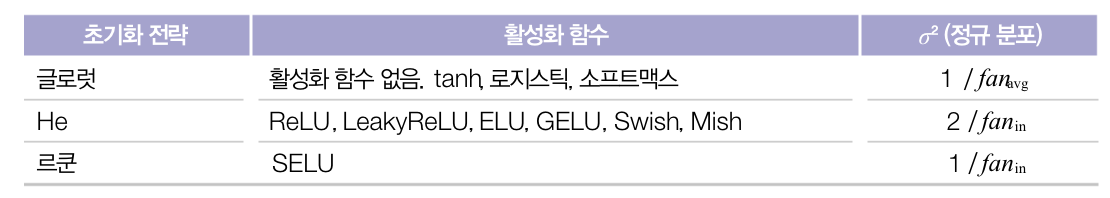

In [1]:
import tensorflow as tf
# 케라스는 글로럿 초기화가 디폴트지만 아래와 같은 방식으로 설정해줄 수 있다.
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

In [2]:
#mode를 통해 어떤 정규분포를 사용할 것인지 설정할 수 있다.
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2, mode="fan_avg", 
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

### 11.1.2 고급 활성화 함수
* ReLU는 큰 학습률을 사용하면 뉴런의 절반이 죽어있는 현상을 보인다. (뉴런이 0만을 출력하면 죽었다고 표현한다.)
* 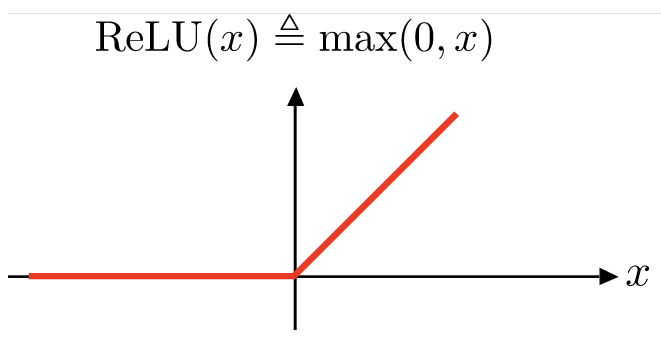
    * 그 대안으로 LeakyReLU같은 ReLU의 변형 함수를 사용한다.
    * LeakyReLu(z) = max(az, z)로 정의된다.
* 음수 부분에서 기울기를 가지기에 죽어있는 뉴런도 살아날 가능성이 있다.
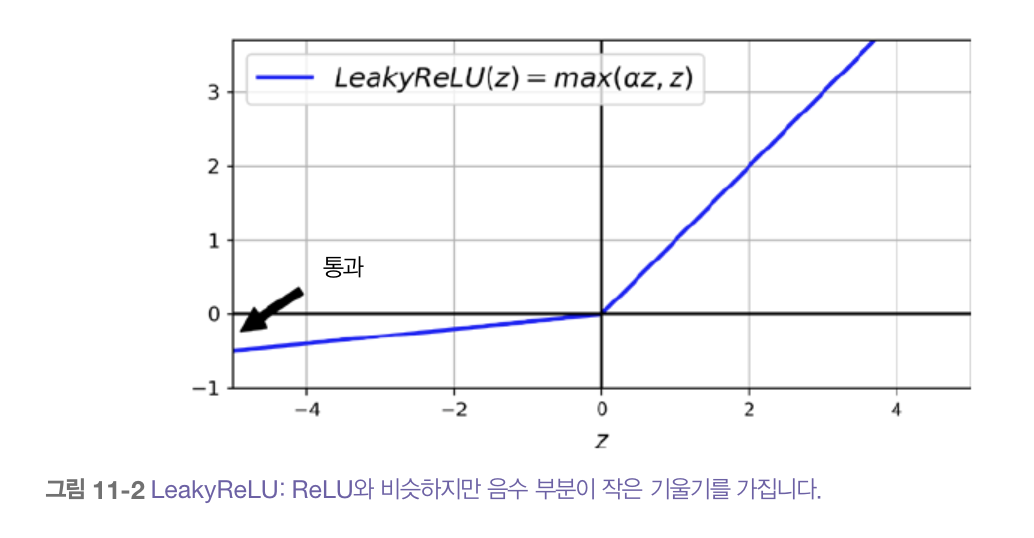

* 훈련하는 동안 주어진 범위에서 a를 랜덤으로 선택하고 테스트 시에는 평균을 사용하는 RReLU(radomized leaky ReLU)도 있다.
* a가 훈련되는 동안 학습 되는 PReLU(Parametric leaky ReLU)이란 것도 있다.

In [3]:
# 아래와 같이 LeakyReLU를 사용할 수 있다.
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

* 위에서 소개한 함수들은 모두 매끄럽지 않은 함수라는 단접이 있다. 
* 그렇기에 ELU라는 새로운 활성화 함수가 있다.
* ELU_a(z) = { a(exp(z) - 1)  z<0일 때
*           z               z>=0일 때

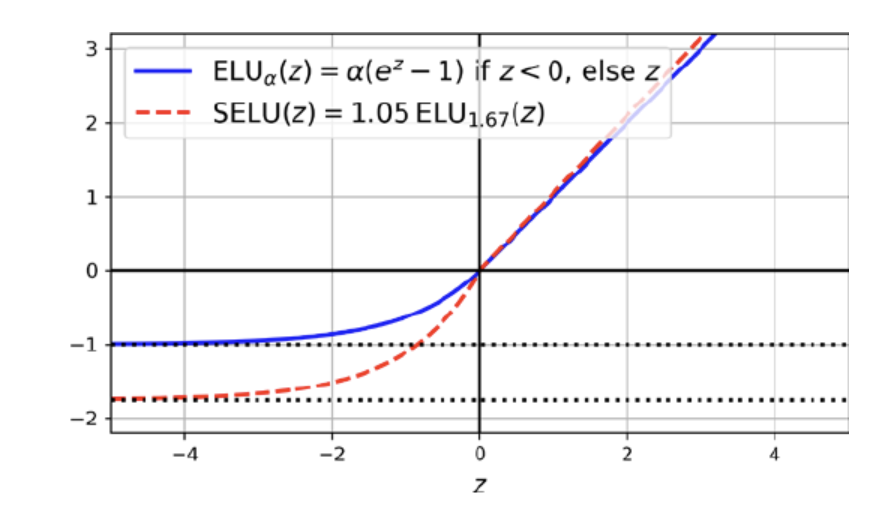  

* GELU도 ReLU의 부드러운 변형이다
*  Φ는 표준 가우스 누적 분포 함수이다.
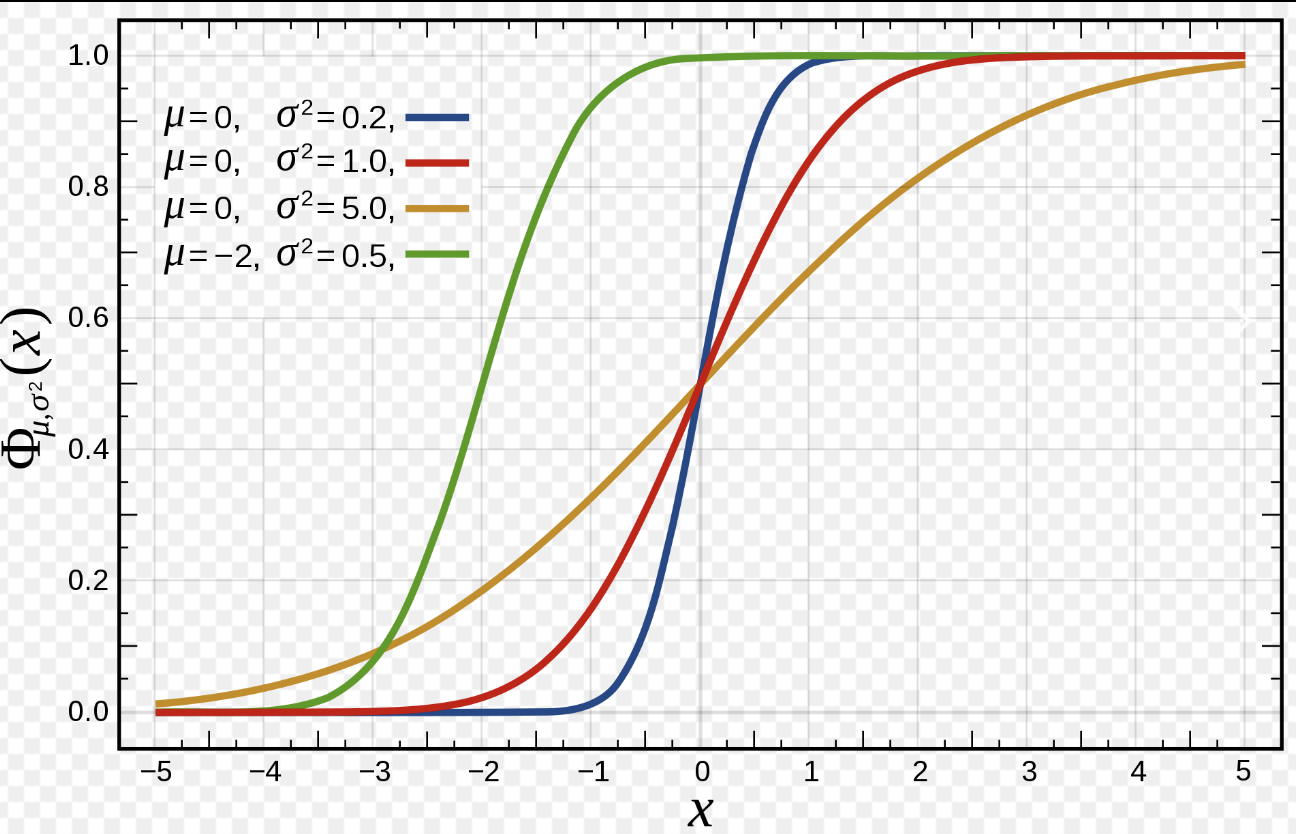
* GELU(z) = zΦ(z)
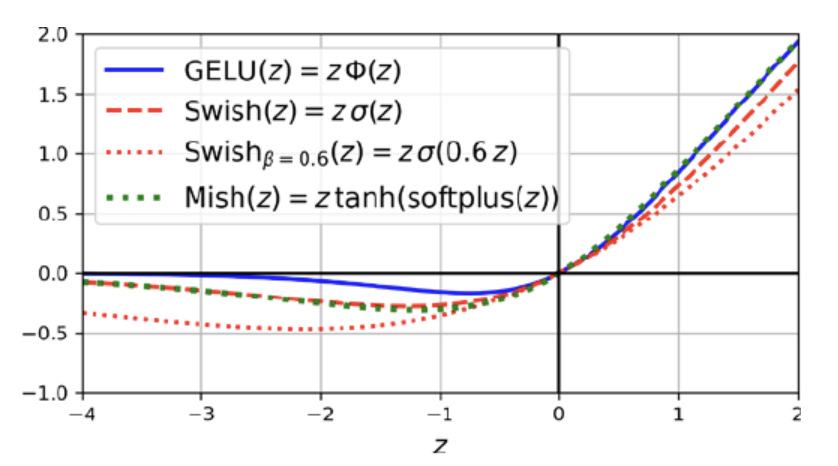


### 11.1.3 배치 정규화
* 위 함수화 초기화 방식을 통해서 훈련 초기에 그레이던트 소실이나 폭주 문제를 크게 줄일 수 있지만
* 훈련 동안 다시 발생하지 않게 막을 방법이 필요하다.
* 그렇기에 배치 정규화를 해야한다.
    * 배치 정규화는 단순이 원점을 0으로 맞추고 스케일을 조정한다.
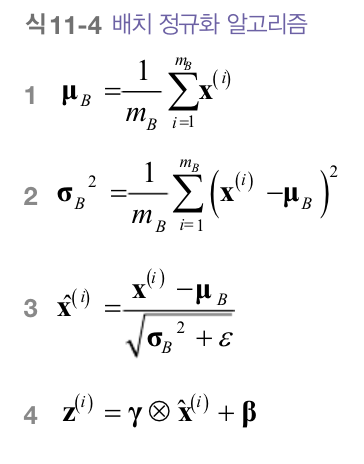
* 위와 같은 알고리즘을 가지고 있다.

* 케라스에선 BatchNormalization layer가 일을 한다.
* 배치 정규화는 그레디언트 소실 문제를 줄이면서 가중치 초기화에 네트워크가 덜 민감해지면서 큰 학습률을 사용할 수 있고 그로인해 학습 과정의 속도를 높일 수 있다.
* 또 규제와 같은 역할을 하여 다른 규제 기법의 필요성을 줄여줍니다.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
]) 

Metal device set to: Apple M2


2024-06-01 12:40:46.917110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-01 12:40:46.917516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.summary()
# batch_normalization 층에선 입력의 4배의 parameter를 가지고 있다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_2 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_3 (Batc  (None, 100)              4

### 11.1.4 그레디언트 클리핑

* 그레디언트 폭주를 막기위한 하나의 방법은 역전파될 때 특정 입계값을 넘어서지 못하게 그레디언트를 잘라내는 것. (그것을 그레디언트 클리핑이라 함)
* 케라스에선 clipvalue, clipnorm 매개변수를 지정하면 된다.

In [8]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0) # 여기선 그레디언트를 [-1, 1]을 넘어가면 자른다.
# clipnorm 1.0는 그레디언트 벡터의 형상을 유지하며 스케일 조정으로 [-1, 1]안으로 되게 해준다.

### 11.2 사전 훈련된 층 재사용하기
* 보통 해결하려는 문제와 비슷한 유형의 문제를 처리한 신경망이 있는지 찾아보지 않고 아주 큰 규모의 DNN을 처음부터 훈련하는 것 좋지 않은 생각이다.
* 보통 최상위 층을 제외하면 대부분의 층을 재사용할 수 있다. (그것을 transfer learning이라고 한다.)

* 보통 상위 은닉층은 하위 은닉 층 보다 덜 유용하다 따라서 재사용할 층 개수를 잘 선정할 수 있어야한다.

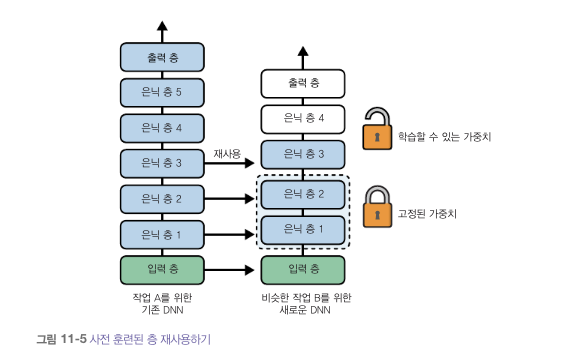

### 11.2.1 케라스를 사용한 전이 학습

In [9]:
# my_model_A는 이미 훈련되어 저장되어있다.
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid")) # 이렇게 되면 B를 훈련 시킬때 A에게도 영향이 가기 때문에 미리 클론 시켜놔야함

OSError: No file or directory found at my_model_A

In [10]:
for layers in model_B_on_A.layers[:-1]: # 먼저 추가된 layer에 적당한 학습을 위해 학습 되어있는 레이어는 훈련을 못하게 한다.
    layer.tainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

NameError: name 'model_B_on_A' is not defined

In [11]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B)) 
# 추가된 레이어가 어느정도 학습 된 후 모든 레이어를 훈련 가능하게 한 후 미세 조정을 해준다. (보통 이때 학습률을 작게 설정한다)

NameError: name 'model_B_on_A' is not defined

### 11.2.2 비지도 사전 훈련

* 레이블된 훈련 데이터를 많이 모으는 것은 비싸다.
* 레이블 되지 않은 훈련 데이터를 많이 모을 수 있다면 이를 사용하여 비지도 학습 모델을 훈련할 수 있다.
* 그런후 그 모델의 하위층을 재사용하고 출력층을 추가하고, 지도학습으로 최종 네트워크를 세밀하게 튜닝할 수 있다.

## 11.3 고속 옵티마이저
### 11.3.1 모멘텀 최적화
* 표준적인 경사 하강법은 경사가 가파를 땐 큰 스텝, 완만할 땐 작은 스텝이지만

* * 

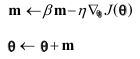
* 모멘텀 최적화에선 이전의 그레디언트를 상당히 중요하게 생각한다. (관성, 가속도이런 물리적 법칙을 보고 카피한듯)


In [12]:
# 모멘텀 최적화
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) # 하이퍼 파라미터가 하나 더 늘어나지만, 빠르다

### 11.3.2 네스테로프 가속 경사
* 모멘텀 최적화의 변형
* 좀더 앞선 부분에서 비용함수의 그레디언트를 계산
* 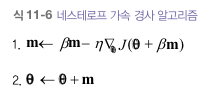

* 아래와 같이 네스테로프 업데이트가 최적값에 더 가깝다.
* 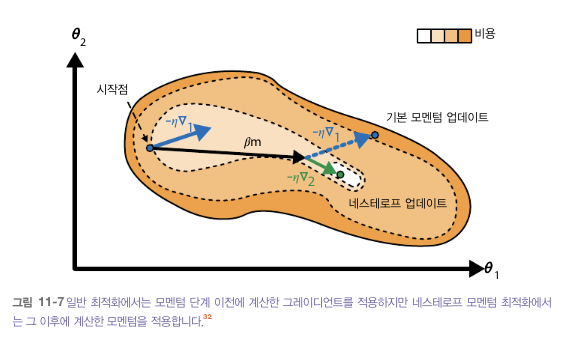

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, use_nesterov=True) #use_nesterov를 통해 사용

### 11.3.3 AdaGrad
* AdaGrad 알고리즘은 가장 가파른 차원을 따라 그레디언트 벡터의 스케일을 감소 시킨다.

### 11.3.5 Adam
* adaptive moment estimation (Adam)
* 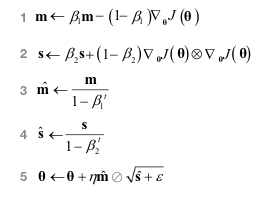

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

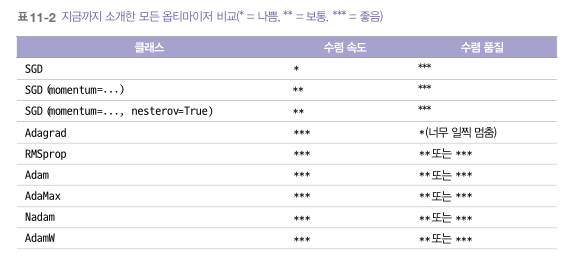

### 11.3.9 학습률 스케줄링
* 좋은 학습률을 찾는 것은 매우 중요하다.
    * 너무 크면 훈련이 발산
    * 너무 작으면 시간이 오래 걸림
* 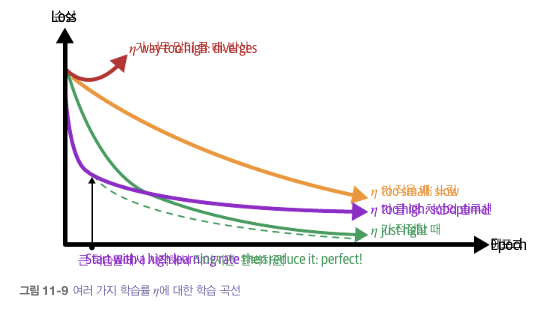
* 위 그래프를 보면 큰 학습률로 빠른 손실의 감소 후 작은 학습률로 최적의 솔루션을 빨리 얻는 것이 좋아보인다. (그것을 하는 것을 학습 스케줄라고 한다.)
* 스케줄링
    * 거듭제곱 기반 스케줄링
    * 지수 기반 스케줄링
    * 구간별 고정 스케줄링
    * 성능 기반 스케줄링
    * 1사이클 스케줄링

In [18]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

## 11.4 규제를 사용해 과대적합 피하기

### 11.4.2 드롭아웃
* 심층 신경망에서 인기 있는 규제 기법이다.
* 보통 10% ~ 50% 사이로 dropout rate를 지정한다.
* 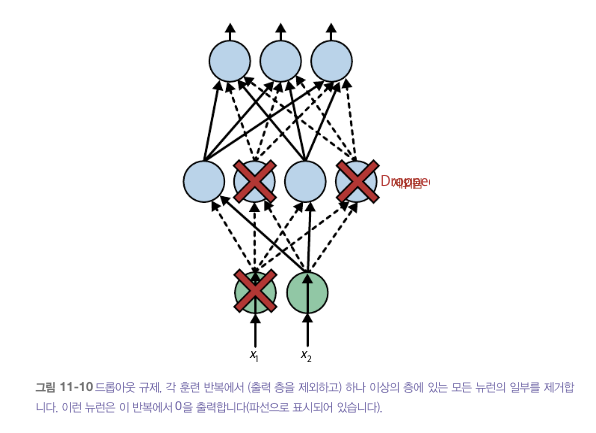

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    
    tf.keras.layers.Dropout(rate=0.2), # 입력의 0.2를 0으로 만들어버린다.
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])